# How to get a mesh from an MRI image?

In [1]:
import pyvista as pv

from polpo.preprocessing import Pipeline, RemoveIndex
from polpo.preprocessing.load import FigsharePregnancyDataLoader
from polpo.preprocessing.mesh.conversion import PvFromData
from polpo.preprocessing.mri import (
    MeshExtractorFromSegmentedImage,
    MriImageLoader,
    SkimageMarchingCubes,
)
from polpo.preprocessing.path import FileFinder, FileRule

[KeOps] Warning : cuda was detected, but driver API could not be initialized. Switching to cpu only.


In [2]:
STATIC_VIZ = True

if STATIC_VIZ:
    pv.set_jupyter_backend("static")

## Loading data

Following [How to visualize MRI data?](./viz_mri.ipynb), we start by [getting the image data](./load_figshare_data.ipynb).

In [3]:
SESSION_ID = 1

In [4]:
folder_name = f"ses-{str(SESSION_ID).zfill(2)}"

loader = FigsharePregnancyDataLoader(
    data_dir="~/.herbrain/data/pregnancy/mri",
    remote_path=f"mri/{folder_name}",
)

finder = FileFinder(
    rules=[
        FileRule(value="BrainNormalized", func="startswith"),
        FileRule(value=".nii.gz", func="endswith"),
    ]
)

pipe = loader + finder + MriImageLoader()

In [5]:
img_fdata = pipe()

INFO: Data has already been downloaded... using cached file ('/home/luisfpereira/.herbrain/data/pregnancy/mri/ses-01').


## Marching cubes

We now use [marching cubes](https://scikit-image.org/docs/stable/api/skimage.measure.html#skimage.measure.marching_cubes
) and transform the output to [pyvista.PolyData](https://docs.pyvista.org/api/core/_autosummary/pyvista.polydata) for visualization.

In [6]:
mesh_from_image = Pipeline(
    [
        SkimageMarchingCubes(),
        lambda x: list(x),
        RemoveIndex(index=-1, inplace=True),
    ]
)

In [7]:
mesh = (mesh_from_image + PvFromData())(img_fdata)

## Visualization

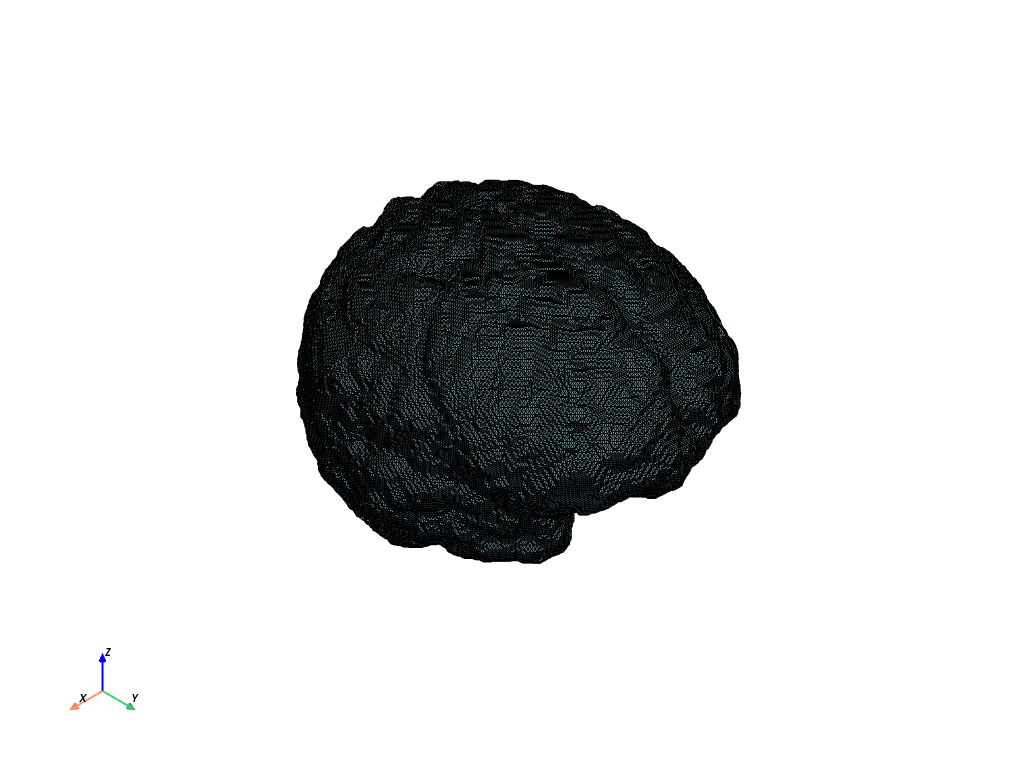

In [8]:
pl = pv.Plotter(border=False)

pl.show_axes()
pl.add_mesh(mesh, show_edges=True)
pl.show()

# Segmented data

Load the segmented data.

In [9]:
folder_name = f"BB{str(SESSION_ID).zfill(2)}"


loader = FigsharePregnancyDataLoader(
    data_dir="~/.herbrain/data/pregnancy/Segmentations",
    remote_path=f"Segmentations/{folder_name}",
)

finder = FileFinder(
    rules=[
        FileRule(value="left", func="startswith"),
        FileRule(value=".nii.gz", func="endswith"),
    ]
)

pipe = loader + finder + MriImageLoader()

In [10]:
img_fdata = pipe()

The process changes only slightly when the data is segmented.

In [11]:
mesh = (MeshExtractorFromSegmentedImage() + PvFromData())(img_fdata)

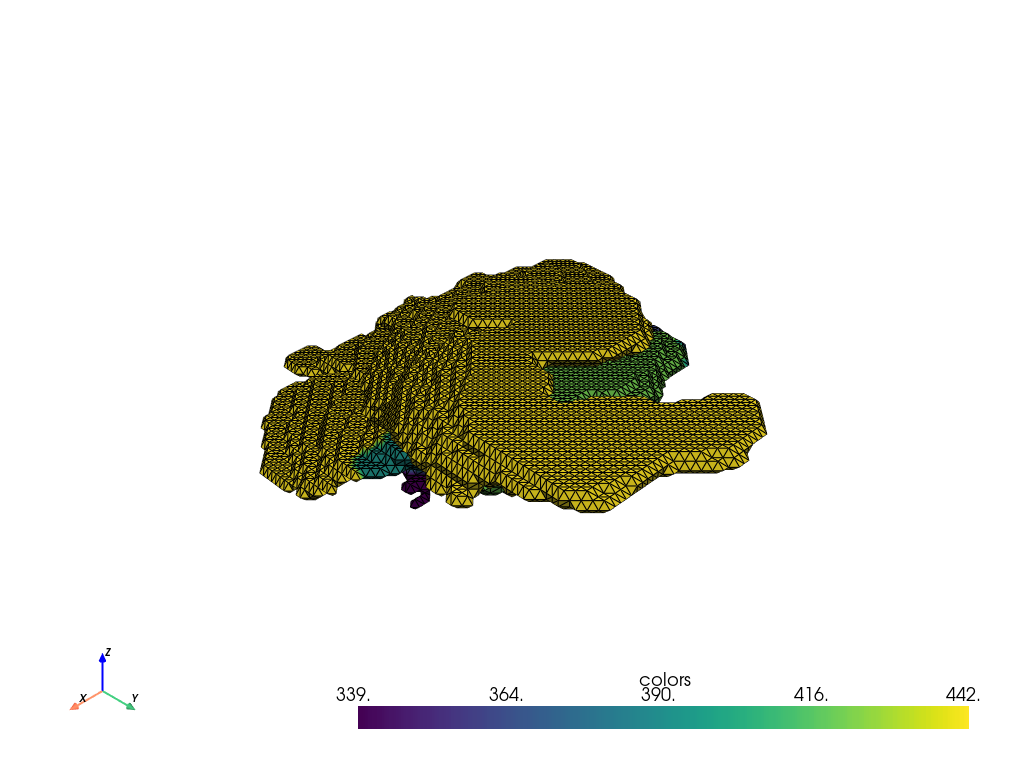

In [12]:
pl = pv.Plotter(border=False)

pl.show_axes()
pl.add_mesh(mesh, show_edges=True)
pl.show()